#Détection de la langue d'un texte

**Le but de ce projet est de programmer un classifieur permettant de détecter la langue d'un texte à partir de la fréquence des bigrammes de ce dernier.**

## Préparation des données

On récupère les corpus de d'apprentissage et de test

In [ ]:
import matplotlib.pyplot as plt
import random
import sys
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import confusion_matrix
import random

In [ ]:
%%bash
rm train.tgz
wget http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/MASCO_Apprentissage_Automatique/train.tgz
tar xvfz train.tgz


train/
train/uk_iu-ud-train.txt
train/zh_gsd-ud-train.txt
train/la_ittb-ud-train.txt
train/af_afribooms-ud-train.txt
train/be_hse-ud-train.txt
train/cs_cac-ud-train.txt
train/fro_srcmf-ud-train.txt
train/hsb_ufal-ud-train.txt
train/mt_mudt-ud-train.txt
train/mr_ufal-ud-train.txt
train/en_lines-ud-train.txt
train/fr_sequoia-ud-train.txt
train/cu_proiel-ud-train.txt
train/fi_ftb-ud-train.txt
train/ro_rrt-ud-train.txt
train/sv_talbanken-ud-train.txt
train/hi_hdtb-ud-train.txt
train/en_esl-ud-train.txt
train/pl_sz-ud-train.txt
train/cs_pdt-ud-train.txt
train/bg_btb-ud-train.txt
train/el_gdt-ud-train.txt
train/fr_partut-ud-train.txt
train/sme_giella-ud-train.txt
train/da_ddt-ud-train.txt
train/qhe_hiencs-ud-train.txt
train/lv_lvtb-ud-train.txt
train/no_nynorsk-ud-train.txt
train/cs_fictree-ud-train.txt
train/en_ewt-ud-train.txt
train/ga_idt-ud-train.txt
train/fr_spoken-ud-train.txt
train/ca_ancora-ud-train.txt
train/sl_sst-ud-train.txt
train/ur_udtb-ud-train.txt
train/got_proiel-ud-train.tx

rm: cannot remove 'train.tgz': No such file or directory
--2021-02-24 07:54:12--  http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/MASCO_Apprentissage_Automatique/train.tgz
Resolving pageperso.lif.univ-mrs.fr (pageperso.lif.univ-mrs.fr)... 139.124.22.27
Connecting to pageperso.lif.univ-mrs.fr (pageperso.lif.univ-mrs.fr)|139.124.22.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29281190 (28M) [application/x-gzip]
Saving to: ‘train.tgz’

     0K .......... .......... .......... .......... ..........  0%  240K 1m59s
    50K .......... .......... .......... .......... ..........  0%  475K 89s
   100K .......... .......... .......... .......... ..........  0% 60.8M 60s
   150K .......... .......... .......... .......... ..........  0% 73.4M 45s
   200K .......... .......... .......... .......... ..........  0%  493K 47s
   250K .......... .......... .......... .......... ..........  1%  206M 39s
   300K .......... .......... .......... .......... ..........  1%

**On fait la liste des fichiers dont on veut se servir pour construire les données d'apprentissage.**
**A chaque corpus on associe un identificateur de la langue (en, fr, it ...)**

In [ ]:
l_corpus_train=[
['en', './train/en_partut-ud-train.txt'],
['fr', './train/fr_sequoia-ud-train.txt'],
['it', './train/it_partut-ud-train.txt'],
['nl', './train/nl_lassysmall-ud-train.txt'],
['sl', './train/sl_sst-ud-train.txt'],
['es', './train/es_ancora-ud-train.txt'],
['pt', './train/pt_bosque-ud-train.txt'],
['de', './train/de_gsd-ud-train.txt'],
['ca', './train/ca_ancora-ud-train.txt']
]

In [ ]:
def calculeCodeLangues(l_corpus):
    nbLangues = 0
    codeLangue = { } # dictionnaire

    for corpus in l_corpus:
        idLangue = corpus[0]
        fichierCorpus = corpus[1]  # Je suis pas sur que ce soit utile pour cette fonction 
        if not idLangue in codeLangue :
          print('langue :', idLangue, 'code = ', nbLangues)
          codeLangue[idLangue] = nbLangues
          nbLangues += 1
    return codeLangue
  
codeLangues = calculeCodeLangues(l_corpus_train)
  

langue : en code =  0
langue : fr code =  1
langue : it code =  2
langue : nl code =  3
langue : sl code =  4
langue : es code =  5
langue : pt code =  6
langue : de code =  7
langue : ca code =  8


**On extrait des corpus d'apprentissage des bigrammes dont on calcule la fréquence.**
**Les fréquences de bigrammes sont stockées dans un fichier dont le format est le suivant :**
**chaque ligne se présente sous la forme de l'identificateur d'une langue, suivie de la fréquence des différents bigrammes dans un ordre fixé (voir la fonction bigram_code())**

In [ ]:
def calculFreq(bigrammes):
    ''' Renvois une liste de fréquence pour chaque code de bigramme '''
    somme = 0 #ici
    for elt in bigrammes :
        somme += elt
    i = 0
    while i < len(bigrammes):
        bigrammes[i] /= somme
        i = i + 1

def afficheBigrammes(bigrammes, fic):
    for frequence in bigrammes :
        print(frequence, ' ', file = fic, end='')
    print('', file = fic)

def char_code(c):
    ''' Chaque lettre est associée à un code '''
    if 'a' <= c and c <= 'z':
        return ord(c) - ord('a') 
    elif c == ' ':
        return 26
    else :
        return 27
    

def bigram_code(c1, c2): 
    ''' Les bigrammes sont définis par des codes '''
    return 27 * char_code(c1) + char_code(c2) # PROPOSITION : la première lettre du bigramme est multiplié par 27 pour augmenter le poids des bigrammes commencant par la lettre c1 

def process_corpus_random(corpus, maxBigrammes, maxTirage):
    try:
        fic = open(corpus, 'r') # ouvre le fichier corpus 
    except IOError:
        print("le fichier", corpus, "n'existe pas")
        return None

    corpus_str = fic.read()  # le fichier est écrit dans corpus_str
    longueur_corpus = len(corpus_str)
#   print("longueur corpus = ", longueur_corpus)
    fic.close() # on ferme le fichier, il est copié dans corpus_str
    
    l_bigrammes = [] # liste de liste 
    tirage = 0
    while tirage < maxTirage: # Pour chaque tirage
        bigrammes = [0] * 784 # 784 car le code associé au bigramme maximum 
        nbBigrammes = 0
        while nbBigrammes <= maxBigrammes : # on cherche le max de bigrammes possibles
            position = random.randint(0,longueur_corpus - 2) # position aléatoire (-2 parce qu'on cherche des bigramme cf voir ligne suivante)
            code_bigramme = bigram_code(corpus_str[position], corpus_str[position + 1]) 
            bigrammes[code_bigramme] += 1 # à la position du code du bigramme dans la liste bigramme on incrémente de 1 
            nbBigrammes += 1
        calculFreq(bigrammes) 
        l_bigrammes.append(bigrammes) # liste dee liste des frequences de bigrammes pour chaque tirage 
        tirage += 1
    return l_bigrammes

def process_corpus_sequential(corpus, maxBigrammes, maxTirage):
    try:
        fic = open(corpus, 'r')
    except IOError:
        print("le fichier", corpus, "n'existe pas")
        return None

    corpus_str = fic.read() 
    longueur_corpus = len(corpus_str) 
#    print("longueur corpus = ", longueur_corpus)
    fic.close() 
    
    l_bigrammes = [] 
    tirage = 0
    while tirage < maxTirage :  
        bigrammes = [0] * 784  
        nbBigrammes = 0
        position = random.randint(0,longueur_corpus - maxBigrammes - 2) 
        while nbBigrammes <= maxBigrammes : 
            code_bigramme = bigram_code(corpus_str[position], corpus_str[position + 1]) 
            bigrammes[code_bigramme] += 1
            nbBigrammes += 1
            position += 1
            
        calculFreq(bigrammes)
        l_bigrammes.append(bigrammes)
        tirage += 1
    return l_bigrammes

def extract_bigrams(l_corpus, mode, nbBigrammes, nbTirages, fichierSortie) :
    try:
        ficOut = open(fichierSortie, 'w') # ouvre un ficher en mode écriture nommée 'train.dat'->cf dernière ligne du chunck
    except IOError:
        print("le fichier", fichierSortie, "n'existe pas")
        exit

    for corpus in l_corpus: 
        idLangue = corpus[0]
        fichierCorpus = corpus[1]
        print('traite corpus', fichierCorpus) 
        if(mode == 'random'):
            l_bigrammes = process_corpus_random(fichierCorpus, nbBigrammes, nbTirages) ##
        else :
            l_bigrammes = process_corpus_sequential(fichierCorpus, nbBigrammes, nbTirages)
        for bigrammes in l_bigrammes:
            print(idLangue, ' ', file = ficOut, end='')
            afficheBigrammes(bigrammes, ficOut)
    ficOut.close()
    
extract_bigrams(l_corpus_train, 'random', 100, 100, 'train.dat')

traite corpus ./train/en_partut-ud-train.txt
traite corpus ./train/fr_sequoia-ud-train.txt
traite corpus ./train/it_partut-ud-train.txt
traite corpus ./train/nl_lassysmall-ud-train.txt
traite corpus ./train/sl_sst-ud-train.txt
traite corpus ./train/es_ancora-ud-train.txt
traite corpus ./train/pt_bosque-ud-train.txt
traite corpus ./train/de_gsd-ud-train.txt
traite corpus ./train/ca_ancora-ud-train.txt


**On met en forme les données de manière à pouvoir les fournir au réseau de neurones pour l'apprentissage**

In [ ]:
def lectureDonnees(nomFichier, codeLangue):
    print(nomFichier)
    try:
        fic = open(nomFichier, 'r')
    except IOError:
        print("le fichier", nomFichier, "n'existe pas")
        return None

    nbLangues = len(codeLangue.keys()) 
    lx = []
    langues = []

    for ligne in fic:
        # Le chaque ligne d'un fichier on enleve les espaces et on récupère 
        ## le premier caractere dans la variable langue
        ligne = ligne.strip('\n\r')
        liste = ligne.split()
        langue = liste.pop(0)
        
        langues.append(codeLangue[langue])
        resultat = [float(x) for x in liste]
        lx.append(resultat)
    fic.close()

    ly = []
    for i in range(len(langues)):
        v = [0] * nbLangues
        v[langues[i]] = 1
        ly.append(v)

    t = list(zip(lx, ly))
    random.shuffle(t)
    lx, ly = list(zip(*t))

    x_train = np.array(lx, dtype="float")
    y_train = np.array(ly, dtype="int")
    print(len(x_train), "exemples lus")
    #print(x_train)
    return (x_train, y_train)



(x_train, y_train) = lectureDonnees('train.dat', codeLangues)


train.dat
900 exemples lus


**On construit la structure du réseau et on fait l'apprentissage**

In [ ]:
model = Sequential() # type de model 
nbLangues = len(codeLangues.keys()) 

model.add(Dense(units=100, activation='tanh', input_dim=28*28)) # premiere couche du RNN 
#model.add(Dropout(0.5))
model.add(Dense(units=nbLangues, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(x_train, y_train, epochs=20, batch_size=16, validation_split=0.2)



Epoch 1/20
45/45 [==============================] - 1s 12ms/step - loss: 2.1852 - accuracy: 0.1835 - val_loss: 2.1420 - val_accuracy: 0.5778
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 2.1140 - accuracy: 0.6946 - val_loss: 2.0488 - val_accuracy: 0.7000
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 2.0059 - accuracy: 0.7784 - val_loss: 1.9049 - val_accuracy: 0.7389
Epoch 4/20
45/45 [==============================] - 0s 2ms/step - loss: 1.8441 - accuracy: 0.8276 - val_loss: 1.7195 - val_accuracy: 0.7444
Epoch 5/20
45/45 [==============================] - 0s 3ms/step - loss: 1.6329 - accuracy: 0.9237 - val_loss: 1.5023 - val_accuracy: 0.9444
Epoch 6/20
45/45 [==============================] - 0s 3ms/step - loss: 1.4321 - accuracy: 0.9485 - val_loss: 1.3057 - val_accuracy: 0.9444
Epoch 7/20
45/45 [==============================] - 0s 3ms/step - loss: 1.2095 - accuracy: 0.9788 - val_loss: 1.1285 - val_accuracy: 0.9722
Epoch 8/20
45/45 [=

**On charge les données de test**

In [ ]:
%%bash
rm test.tgz
wget http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/MASCO_Apprentissage_Automatique/test.tgz
tar xvfz test.tgz


test/
test/cs_fictree-ud-test.txt
test/akk_pisandub-ud-test.txt
test/la_ittb-ud-test.txt
test/gl_ctg-ud-test.txt
test/bg_btb-ud-test.txt
test/sv_talbanken-ud-test.txt
test/hi_hdtb-ud-test.txt
test/fi_pud-ud-test.txt
test/et_edt-ud-test.txt
test/ga_idt-ud-test.txt
test/da_ddt-ud-test.txt
test/br_keb-ud-test.txt
test/ja_pud-ud-test.txt
test/cs_pdt-ud-test.txt
test/pl_lfg-ud-test.txt
test/no_nynorsk-ud-test.txt
test/pt_bosque-ud-test.txt
test/id_pud-ud-test.txt
test/bm_crb-ud-test.txt
test/kpv_ikdp-ud-test.txt
test/ar_padt-ud-test.txt
test/kk_ktb-ud-test.txt
test/ar_nyuad-ud-test.txt
test/hy_armtdp-ud-test.txt
test/fi_ftb-ud-test.txt
test/it_postwita-ud-test.txt
test/fa_seraji-ud-test.txt
test/en_partut-ud-test.txt
test/zh_pud-ud-test.txt
test/cs_pud-ud-test.txt
test/sk_snk-ud-test.txt
test/tr_imst-ud-test.txt
test/eu_bdt-ud-test.txt
test/got_proiel-ud-test.txt
test/ug_udt-ud-test.txt
test/kpv_lattice-ud-test.txt
test/ru_taiga-ud-test.txt
test/ru_syntagrus-ud-test.txt
test/wbp_ufal-ud-tes

rm: cannot remove 'test.tgz': No such file or directory
--2021-02-24 07:55:05--  http://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/MASCO_Apprentissage_Automatique/test.tgz
Resolving pageperso.lif.univ-mrs.fr (pageperso.lif.univ-mrs.fr)... 139.124.22.27
Connecting to pageperso.lif.univ-mrs.fr (pageperso.lif.univ-mrs.fr)|139.124.22.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5342409 (5.1M) [application/x-gzip]
Saving to: ‘test.tgz’

     0K .......... .......... .......... .......... ..........  0%  237K 22s
    50K .......... .......... .......... .......... ..........  1%  488K 16s
   100K .......... .......... .......... .......... ..........  2% 92.1M 11s
   150K .......... .......... .......... .......... ..........  3%  498K 10s
   200K .......... .......... .......... .......... ..........  4% 73.3M 8s
   250K .......... .......... .......... .......... ..........  5%  498K 8s
   300K .......... .......... .......... .......... ..........  6% 69.4M 

In [ ]:
l_corpus_test=[
['en', './test/en_partut-ud-test.txt'],
['fr', './test/fr_sequoia-ud-test.txt'],
['it', './test/it_partut-ud-test.txt'],
['nl', './test/nl_lassysmall-ud-test.txt'],
['sl', './test/sl_sst-ud-test.txt'],
['es', './test/es_ancora-ud-test.txt'],
['pt', './test/pt_bosque-ud-test.txt'],
['de', './test/de_gsd-ud-test.txt'],
['ca', './test/ca_ancora-ud-test.txt']
]

In [ ]:
extract_bigrams(l_corpus_test, 'random', 500, 10, 'test.dat')
(x_test, y_test) = lectureDonnees('test.dat', codeLangues)

traite corpus ./test/en_partut-ud-test.txt
traite corpus ./test/fr_sequoia-ud-test.txt
traite corpus ./test/it_partut-ud-test.txt
traite corpus ./test/nl_lassysmall-ud-test.txt
traite corpus ./test/sl_sst-ud-test.txt
traite corpus ./test/es_ancora-ud-test.txt
traite corpus ./test/pt_bosque-ud-test.txt
traite corpus ./test/de_gsd-ud-test.txt
traite corpus ./test/ca_ancora-ud-test.txt
test.dat
90 exemples lus


**On évalue le modèle sur les données de test**

In [ ]:
def l_identifiants(cdLg) : 
  id = [''] * len(cdLg)
  for (key, val) in (cdLg.items()):
  #print("key =", key , 'val =', val)
    id[int(val)] = key
  return id

l_id = l_identifiants(codeLangues)
print(l_id)

['en', 'fr', 'it', 'nl', 'sl', 'es', 'pt', 'de', 'ca']


In [ ]:
def argmax(l):
  ''' Renvoie la position de l'argument maximum de la liste '''
  i = 1
  max = l[0] 
  arg = 0
  while i < len(l) :
    if l[i] > max :
      max = l[i]
      arg = i
    i = i + 1
  return arg

score = model.evaluate(x_test, y_test)
print(model.metrics_names) # noms des données de l'output de model.evaluate 
print('test.dat score = ', score)
l_pred = model.predict(x_test, batch_size=None, verbose=1, steps=None) 
i = 0
while i < len(l_pred) :
  #print(l_pred[i])
  predicted = l_id[argmax(l_pred[i])]
  gold = l_id[argmax(y_test[i])]
  #print('pred =', predicted, 'gold =', gold)
  i = i + 1

  
def note(pred, y_t, cdlg) : 
  nt = [0]*len(cdlg)
  i = 0
  while i < len(pred) : 
    if argmax(pred[i]) == argmax(y_t[i]) : 
      nt[argmax(pred[i])] += 1 
    i += 1
  
  i = 0
  while i < len(nt) : 
    nt[i] /= len(pred)/len(cdlg)
    i += 1

  return nt

note(l_pred, y_test, codeLangues)



3/3 [==============================] - 0s 3ms/step - loss: 0.1972 - accuracy: 1.0000
['loss', 'accuracy']
test.dat score =  [0.1971767395734787, 1.0]
3/3 [==============================] - 0s 3ms/step


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# Projets de recherche 

- "Taille des données d’apprentissage. Les performances obtenues par le classifieur dépendent du nombre d’exemples vus lors de l’apprentissage. Il est possible de tracer une courbe d’apprentissage donnant les performances du réseau selon la taille des données d’apprentissage pour chacune des langues. Toutes les langues ont-elles besoin d’autant de données ? pourquoi ?"

- "Certaines langues sont elles plus difficiles à distinguer que d’autres ? est ce qu’une matrice de confusion nous permet de retrouver des familles de langues ?"

## Projet 1

Nous souhaitons dans notre permier projet observer l'évolution de la performance du classifieur lorsque nous faisons varier le nombre de bigrammes, et le nombre de langues. De cette manière nous ferons varier la taille de nos données d'apprentissage, nous acquerrons plus de précision en fonction des langues, et pourrons donc les comparer.



### L'évolution en fonction du nombre de bigrammes 

Dans un premier temps, nous voulons regarder l'évolution des valeurs de la fonction de perte "loss" en fonction du nombre de bigrammes : nous créeons donc une boucle dans laquelle le nombre de bigrammes augmente, et représentons ces résultats dans un graphique.

Nous pourrons donc voir, pour l'ensemble des langues combien il faut de bigrammes pour que la fonction de pertes se rapproche de 0.


langue : en code =  0
langue : fr code =  1
langue : it code =  2
langue : nl code =  3
langue : sl code =  4
langue : es code =  5
langue : pt code =  6
langue : de code =  7
langue : ca code =  8
traite corpus ./test/en_partut-ud-test.txt
traite corpus ./test/fr_sequoia-ud-test.txt
traite corpus ./test/it_partut-ud-test.txt
traite corpus ./test/nl_lassysmall-ud-test.txt
traite corpus ./test/sl_sst-ud-test.txt
traite corpus ./test/es_ancora-ud-test.txt
traite corpus ./test/pt_bosque-ud-test.txt
traite corpus ./test/de_gsd-ud-test.txt
traite corpus ./test/ca_ancora-ud-test.txt
test_2.dat
90 exemples lus
/n 50 / 700 /n
traite corpus ./train/en_partut-ud-train.txt
traite corpus ./train/fr_sequoia-ud-train.txt
traite corpus ./train/it_partut-ud-train.txt
traite corpus ./train/nl_lassysmall-ud-train.txt
traite corpus ./train/sl_sst-ud-train.txt
traite corpus ./train/es_ancora-ud-train.txt
traite corpus ./train/pt_bosque-ud-train.txt
traite corpus ./train/de_gsd-ud-train.txt
traite corpus .

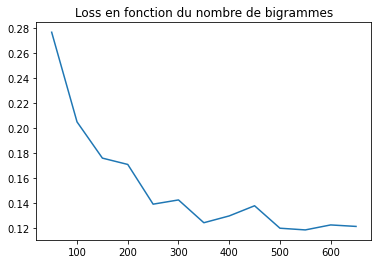

In [ ]:
l_corpus_train=[
['en', './train/en_partut-ud-train.txt'],
['fr', './train/fr_sequoia-ud-train.txt'],
['it', './train/it_partut-ud-train.txt'],
['nl', './train/nl_lassysmall-ud-train.txt'],
['sl', './train/sl_sst-ud-train.txt'],
['es', './train/es_ancora-ud-train.txt'],
['pt', './train/pt_bosque-ud-train.txt'],
['de', './train/de_gsd-ud-train.txt'],
['ca', './train/ca_ancora-ud-train.txt']
]

codeLangues = calculeCodeLangues(l_corpus_train)
l_id = l_identifiants(codeLangues)

l_corpus_test=[
['en', './test/en_partut-ud-test.txt'],
['fr', './test/fr_sequoia-ud-test.txt'],
['it', './test/it_partut-ud-test.txt'],
['nl', './test/nl_lassysmall-ud-test.txt'],
['sl', './test/sl_sst-ud-test.txt'],
['es', './test/es_ancora-ud-test.txt'],
['pt', './test/pt_bosque-ud-test.txt'],
['de', './test/de_gsd-ud-test.txt'],
['ca', './test/ca_ancora-ud-test.txt']
]

extract_bigrams(l_corpus_test, 'random', 500, 10, 'test_2.dat')
(x_test_2, y_test_2) = lectureDonnees('test_2.dat', codeLangues)

def maxbigramms_variation(max_bigramms, corpus_train = l_corpus_train, cd_lg = codeLangues, x_tst = x_test_2, y_tst = y_test_2) :
    ''' Fait varier le nombre de bigrammes durant la phase d'entrainement et qui renvoie les scores du model en fonction
    '''
    los =[]
    accur = []
    lg = []

    for bigram in range(50,max_bigramms,50):

      print("/n", bigram,'/', max_bigramms, "/n")
    
      extract_bigrams(corpus_train, 'random', bigram, 100, 'train_iter.dat')
      (x_train_iter, y_train_iter) = lectureDonnees('train_iter.dat', cd_lg)

      model = Sequential() # type de model 
      nbLangues = len(cd_lg.keys()) 
      model.add(Dense(units=100, activation='tanh', input_dim=28*28)) # premiere couche du RNN 
      model.add(Dense(units=nbLangues, activation='softmax'))
      model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
      model.fit(x_train_iter, y_train_iter, epochs=20, batch_size=16, validation_split=0.2)

      score = model.evaluate(x_tst, y_tst)

      los.append(score[0])
      accur.append(score[1])

    x = np.array([x*50 for x in range(1,max_bigramms//50)])
    y = np.array(los)
    plt.title('Loss en fonction du nombre de bigrammes')
    plt.plot(x, y)


    y = np.array(accur)
    #plt.title('Accur en fonction du nombre de bigrammes')
    #plt.plot(x, y)

maxbigramms_variation(700)




Le graphique ci-dessus représente les valeurs finales de la fonction de perte en fonction du nombre de bigramme avec lequel le modèle a été entrainé. 

Nous observons qu'en augmentant le nombre de bigrammes, notre perte est minimale autour de 600 bigrammes, ensuite elle réaugmente. Nous pouvons émettre l'hypothèse que cette nouvelle augmentation du loss est dûe à un début de surapprentissage du classifieur, dans la suite de ce travail nous resterons donc à ce nombre de bigrammes pour garder cette précision.

Si nous voulions être plus exacte sur la précision de la valeur minimale de la perte, nous pourrions faire une moyenne de plusieurs courbes, et voir où se situe en moyenne la perte la plus petite.

### Taille de l'échantillon nécessaire pour l'apprentissage d'une langue en particulier sur un grand nombre de données 

Nous voulons maintenant voir l'influence de l'augmentation du nombre de  langues dans le classifieur. Nous rajoutons donc au corpus dix langues, et réalisons le même traitement qu'au début, c'est-à-dire que nous faisons varier le nombre de bigrammes.


In [ ]:
l_corpus_train=[
['en', './train/en_partut-ud-train.txt'],
['fr', './train/fr_sequoia-ud-train.txt'],
['it', './train/it_partut-ud-train.txt'],
['nl', './train/nl_lassysmall-ud-train.txt'],
['sl', './train/sl_sst-ud-train.txt'],
['es', './train/es_ancora-ud-train.txt'],
['pt', './train/pt_bosque-ud-train.txt'],
['de', './train/de_gsd-ud-train.txt'],
['ca', './train/ca_ancora-ud-train.txt'],
['af', './train/af_afribooms-ud-train.txt'],
['el', './train/el_gdt-ud-train.txt'],
['be', './train/be_hse-ud-train.txt'],
['ja', './train/ja_gsd-ud-train.txt'],
['kk', './train/kk_ktb-ud-train.txt'],
['la', './train/la_ittb-ud-train.txt'], 
['ar', './train/ar_nyuad-ud-train.txt'], 
['bg','./train/be_hse-ud-train.txt'], 
['bxr', './train/bxr_bdt-ud-train.txt'],
['cop', './train/cop_scriptorium-ud-train.txt']
]

codeLangues = calculeCodeLangues(l_corpus_train)
l_id = l_identifiants(codeLangues)

l_corpus_test=[
['en', './test/en_partut-ud-test.txt'],
['fr', './test/fr_sequoia-ud-test.txt'],
['it', './test/it_partut-ud-test.txt'],
['nl', './test/nl_lassysmall-ud-test.txt'],
['sl', './test/sl_sst-ud-test.txt'],
['es', './test/es_ancora-ud-test.txt'],
['pt', './test/pt_bosque-ud-test.txt'],
['de', './test/de_gsd-ud-test.txt'],
['ca', './test/ca_ancora-ud-test.txt'],
['af', './test/af_afribooms-ud-test.txt'],
['el', './test/el_gdt-ud-test.txt'],
['be', './test/be_hse-ud-test.txt'],
['ja', './test/ja_gsd-ud-test.txt'],
['kk', './test/kk_ktb-ud-test.txt'],
['la', './test/la_ittb-ud-test.txt'],
['ar', './test/ar_nyuad-ud-test.txt'], 
['bg','./test/be_hse-ud-test.txt'], 
['bxr', './test/bxr_bdt-ud-test.txt'],
['cop', './test/cop_scriptorium-ud-test.txt']
]

extract_bigrams(l_corpus_test, 'random', 500, 10, 'test_3.dat')
(x_test_3, y_test_3) = lectureDonnees('test_3.dat', codeLangues)

def maxbigramms_variation_2(max_bigramms, corpus_train = l_corpus_train, cd_lg = codeLangues, x_tst = x_test_3, y_tst = y_test_3) :
    ''' Fait varier le nombre de bigrammes durant la phase d'entrainement et qui renvoie les scores du model en fonction
    '''
    los =[]
    accur = []
    lg = []

    for bigram in range(50,max_bigramms,50):

      print("/n", bigram,'/', max_bigramms, "/n")
    
      extract_bigrams(corpus_train, 'random', bigram, 100, 'train_iter.dat')
      (x_train_iter, y_train_iter) = lectureDonnees('train_iter.dat', cd_lg)

      model = Sequential() # type de model 
      nbLangues = len(cd_lg.keys()) 
      model.add(Dense(units=100, activation='tanh', input_dim=28*28)) # premiere couche du RNN 
      model.add(Dense(units=nbLangues, activation='softmax'))
      model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
      model.fit(x_train_iter, y_train_iter, epochs=20, batch_size=16, validation_split=0.2)

      l_pred = model.predict(x_tst, batch_size=None, verbose=1, steps=None) 

      lg.append(note(l_pred, y_tst, cd_lg))

    return lg

mx_big = 700
lang = maxbigramms_variation_2(max_bigramms = mx_big)



#print('toutes les langues possibles ', l_id)
#print('Accuraccy avec le maximum de bigrammes ', lang[-1])

#print('toutes accuracy pour une langue donnée',[i[-3] for i in lang])



langue : en code =  0
langue : fr code =  1
langue : it code =  2
langue : nl code =  3
langue : sl code =  4
langue : es code =  5
langue : pt code =  6
langue : de code =  7
langue : ca code =  8
langue : af code =  9
langue : el code =  10
langue : be code =  11
langue : ja code =  12
langue : kk code =  13
langue : la code =  14
langue : ar code =  15
langue : bg code =  16
langue : bxr code =  17
langue : cop code =  18
traite corpus ./test/en_partut-ud-test.txt
traite corpus ./test/fr_sequoia-ud-test.txt
traite corpus ./test/it_partut-ud-test.txt
traite corpus ./test/nl_lassysmall-ud-test.txt
traite corpus ./test/sl_sst-ud-test.txt
traite corpus ./test/es_ancora-ud-test.txt
traite corpus ./test/pt_bosque-ud-test.txt
traite corpus ./test/de_gsd-ud-test.txt
traite corpus ./test/ca_ancora-ud-test.txt
traite corpus ./test/af_afribooms-ud-test.txt
traite corpus ./test/el_gdt-ud-test.txt
traite corpus ./test/be_hse-ud-test.txt
traite corpus ./test/ja_gsd-ud-test.txt
traite corpus ./tes

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.  0.2 0.8 0.  0.  0.  0.3 0.  0.  0.  0.7 0.  0. ]
[0.6 0.5 0.  0.8 0.8 0.3 0.  0.  0.3 0.5 0.  0.  0. ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.  0.4 0.  0.  0.  0.5 0.  0.  0.5 0.3 0.  0.  0.1]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.  0.  0.3 0.  0.  0.  0.7 0.5 0.  0.  0.5 0.7 0.5]
[0.  0.1 0.  0.1 0.1 0.  0.  0.2 0.  0.  0.  0.1 0.1]
[0.9 0.  0.  0.  0.  0.9 0.6 0.  0.5 0.6 0.2 0.9 0.6]


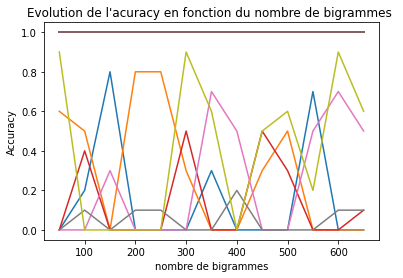

In [ ]:
x = np.array([x*50 for x in range(1,mx_big//50)])
for j in range(0,len(codeLangues)) : 
  y = np.array([i[j] for i in lang])
  print(y)
  plt.plot(x, y)

plt.title("Evolution de l'acuracy en fonction du nombre de bigrammes ")
plt.xlabel("nombre de bigrammes")
plt.ylabel("Accuracy")
plt.show()

Nous avons récupéré dans la liste précédente le premier endroit où l’accuracy est au maximum puis nous avons mis sur un même graphe nos différentes langues pour les comparer.

Nous observons dans ces résultats que pour six langues, la taille de nos données ne permettent pas de déterminer avec certitude la langue  : pour les autres, l'accuracy est déjà dès le début à son maximum.

Selon les tirages, il n'y a pas le même nombre de langues qui ne sont pas discriminées complétement, comme precedemment nous pourrions faire des moyennes sur plusieurs tirages pour voir s'il y a des langues qui ressortent particulièrement dans les erreurs de reconnaissance.

Cet apprentissage connait ainsi des limites selon les langues d'entrainement et de test, il serait alors interessant dans un projet futur de voir quelles sont ces langues, et avec lesquelles elles sont confondues.

Nous allons maintenant déterminer le nombre de données qu'il faut au sein de chaque langue pour avoir la meilleure exactitude.


### Nombre de données permettant la meilleure détection pour chaque langue dans le corpus précédent 

In [ ]:
n =0
for  j in codeLangues: 
  l = [i[n] for i in lang]
  y = argmax(l) + 1
  print('La langue '+j + ' a la detection la plus haute à partir de la '+ str(y) + ' itération (50 bigrammes/itération)')
  n += 1

La langue en a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue fr a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue it a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue nl a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue sl a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue es a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue pt a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue de a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue ca a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue af a la detection la plus haute à partir de la 1 itération (50 bigrammes/itération)
La langue el a la detection la plus haute à partir de la 3 i

Nous observons une nouvelle fois que pour la majorité des langues, il suffit d'une itération, soient 50 bigrammes pour que notre seuil de détection soit au plus haut.

Pour d'autres langues en revanche, il faut plus d'étapes d'entrainement, par exemple dans ce tirage pour "bxr" il en faut 8, nous avons donc des disparités de reconnaissance en fonction des langues : certaines ont besoin de plus de bigrammes que d'autres afin de garantir leur reconnaissance.

Puisque nous n'avons pas de résultats homogènes entres les langues, nous pouvons dire qu'il ne faut pas le même nombre de données pour reconnaître chaque langue : certaines en nécessitent plus que d'autres indépendamment de la taille du corpus de langue. Un grand corpus entraine des résultats moins bons qu'un plus petit, mais ce nombre de corpus varie en fonction de la langue étudiée.


L'augmentation du nombre de bigrammes ne se fait pas non plus sans risque de surapprentissage : plus nous augmentons le nombre de bigrammes et plus il est possible de tomber sur des bigrammes peu fréquents dans une langue, induisant une mauvaise interprétation du classifieur. Ainsi à partir d'un nombre trop grand de données en entrées, nous pouvons plus facilement tomber sur des exceptions qui n'en seraient pas dans d'autres langues, ce qui réduirait la précision de notre classifieur.

De plus, les langues ayant des constructions syntaxiques et grammaticales précodées dans le langage naturel, il n'en existe pas une infinité de bigrammes différents, il faut alors en fonction des langues le nombre de bigrammes adapté pour qu'il soit à la fois représentatif des fréquences les plus observées, et à la fois incomplet pour qu'il ne trompe pas la détermination de la langue.

Il nous faudrait donc extraire un nombre particulier et adapté de bigrammes pour chacune des langues dans le classifieur.


## Projet 2 
Nous voulons maintenant étudier comment nous pouvons distinguer les langues entre elles.

Pour ce faire, nous allons comparer les résultats avec un matrice de confusion, dans laquelle nous rentrons les données prédites et les données observées pour chacune des langues. Nous ajoutons alors le nombre de prédictions correctes entre elles : celle de non-reconnaissances justes, et celle de reconnaissances de bigrammes justes.


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
l_corpus_train=[
['en', './train/en_partut-ud-train.txt'],
['fr', './train/fr_sequoia-ud-train.txt'],
['it', './train/it_partut-ud-train.txt'],
['nl', './train/nl_lassysmall-ud-train.txt'],
['sl', './train/sl_sst-ud-train.txt'],
['es', './train/es_ancora-ud-train.txt'],
['pt', './train/pt_bosque-ud-train.txt'],
['de', './train/de_gsd-ud-train.txt'],
['ca', './train/ca_ancora-ud-train.txt']
]

codeLangues = calculeCodeLangues(l_corpus_train)
l_id = l_identifiants(codeLangues)

l_corpus_test=[
['en', './test/en_partut-ud-test.txt'],
['fr', './test/fr_sequoia-ud-test.txt'],
['it', './test/it_partut-ud-test.txt'],
['nl', './test/nl_lassysmall-ud-test.txt'],
['sl', './test/sl_sst-ud-test.txt'],
['es', './test/es_ancora-ud-test.txt'],
['pt', './test/pt_bosque-ud-test.txt'],
['de', './test/de_gsd-ud-test.txt'],
['ca', './test/ca_ancora-ud-test.txt']
]

extract_bigrams(l_corpus_train, 'random', 600, 100, 'train_p2.dat')
(x_train, y_train) = lectureDonnees('train_p2.dat', codeLangues)

extract_bigrams(l_corpus_test, 'random', 500, 10, 'test_p2.dat')
(x_test_2, y_test_2) = lectureDonnees('test_p2.dat', codeLangues)

model = Sequential() # type de model 
nbLangues = len(codeLangues.keys()) 
model.add(Dense(units=100, activation='tanh', input_dim=28*28)) # premiere couche du RNN 
model.add(Dense(units=nbLangues, activation='softmax'))
model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=16, validation_split=0.2)
l_pred = model.predict(x_test, batch_size=None, verbose=1, steps=None) 



langue : en code =  0
langue : fr code =  1
langue : it code =  2
langue : nl code =  3
langue : sl code =  4
langue : es code =  5
langue : pt code =  6
langue : de code =  7
langue : ca code =  8
traite corpus ./train/en_partut-ud-train.txt
traite corpus ./train/fr_sequoia-ud-train.txt
traite corpus ./train/it_partut-ud-train.txt
traite corpus ./train/nl_lassysmall-ud-train.txt
traite corpus ./train/sl_sst-ud-train.txt
traite corpus ./train/es_ancora-ud-train.txt
traite corpus ./train/pt_bosque-ud-train.txt
traite corpus ./train/de_gsd-ud-train.txt
traite corpus ./train/ca_ancora-ud-train.txt
train_p2.dat
900 exemples lus
traite corpus ./test/en_partut-ud-test.txt
traite corpus ./test/fr_sequoia-ud-test.txt
traite corpus ./test/it_partut-ud-test.txt
traite corpus ./test/nl_lassysmall-ud-test.txt
traite corpus ./test/sl_sst-ud-test.txt
traite corpus ./test/es_ancora-ud-test.txt
traite corpus ./test/pt_bosque-ud-test.txt
traite corpus ./test/de_gsd-ud-test.txt
traite corpus ./test/ca_a

[[10. 10. 10. 10. 10. 10. 10. 10. 10.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[10.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.]]


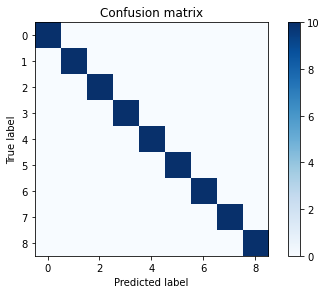

In [ ]:
#print(l_pred)
pred_bool = []


for i in l_pred : 
  max = argmax(i)
  sous_l = []
  for j in range(len(i)) :
    if j == max : 
      sous_l.append(1)
    else : 
      sous_l.append(0)
  pred_bool.append(sous_l)

#print(pred_bool)


mat_vf = np.zeros(shape = [2,9])

for index, i in enumerate(y_test) : 
  if argmax(i) == argmax(pred_bool[index]) : 
    mat_vf[0][argmax(i)] +=1 
  else : 
    mat_vf[1][argmax(i)] +=1 

print(mat_vf)


mat_confusion = np.zeros(shape = [9,9])

for index, i in enumerate(y_test) : 
  if argmax(i) == argmax(pred_bool[index]) : 
    mat_confusion[argmax(pred_bool[index])][argmax(i)] +=1 
  else : 
    mat_confusion[argmax(i)][pred_bool[index]] +=1 

print(mat_confusion)


y_test_ind = []
for i in y_test : 
  y_test_ind.append(argmax(i))

pred_ind = []
for i in pred_bool : 
  pred_ind.append(argmax(i))

cm = confusion_matrix(y_test_ind, pred_ind)

plot_confusion_matrix(cm)
    

On obtient une matrice de confusion indiquant que tout est juste pour chacune des langues du premier pool.
Precedemment nous avons observé que nos accuracy étaient à 1 pour ces langues, expliquant peut-être pourquoi nous n'observons aucune erreur de prédiction depuis cette matrice de confusion.

On se retrouve dans un résultat quasi-parfait. Si ce n'était pas le cas, nous aurions d'autres carrés colorés dans notre matrice, indépendamment de la diagonale.

Nous décidons de rajouter les mêmes dix langues que dans le premier projet pour voir si ces résultats sont similaires aux huit premières langues.

langue : en code =  0
langue : fr code =  1
langue : it code =  2
langue : nl code =  3
langue : sl code =  4
langue : es code =  5
langue : pt code =  6
langue : de code =  7
langue : ca code =  8
langue : af code =  9
langue : el code =  10
langue : be code =  11
langue : ja code =  12
langue : kk code =  13
langue : la code =  14
langue : ar code =  15
langue : bg code =  16
langue : bxr code =  17
langue : cop code =  18
traite corpus ./test/en_partut-ud-test.txt
traite corpus ./test/fr_sequoia-ud-test.txt
traite corpus ./test/it_partut-ud-test.txt
traite corpus ./test/nl_lassysmall-ud-test.txt
traite corpus ./test/sl_sst-ud-test.txt
traite corpus ./test/es_ancora-ud-test.txt
traite corpus ./test/pt_bosque-ud-test.txt
traite corpus ./test/de_gsd-ud-test.txt
traite corpus ./test/ca_ancora-ud-test.txt
traite corpus ./test/af_afribooms-ud-test.txt
traite corpus ./test/el_gdt-ud-test.txt
traite corpus ./test/be_hse-ud-test.txt
traite corpus ./test/ja_gsd-ud-test.txt
traite corpus ./tes

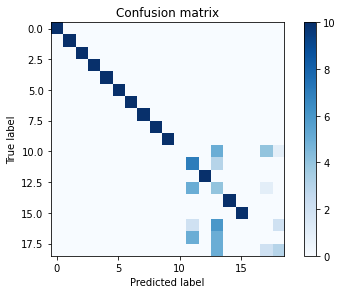

In [ ]:
l_corpus_train=[
['en', './train/en_partut-ud-train.txt'],
['fr', './train/fr_sequoia-ud-train.txt'],
['it', './train/it_partut-ud-train.txt'],
['nl', './train/nl_lassysmall-ud-train.txt'],
['sl', './train/sl_sst-ud-train.txt'],
['es', './train/es_ancora-ud-train.txt'],
['pt', './train/pt_bosque-ud-train.txt'],
['de', './train/de_gsd-ud-train.txt'],
['ca', './train/ca_ancora-ud-train.txt'],
['af', './train/af_afribooms-ud-train.txt'],
['el', './train/el_gdt-ud-train.txt'],
['be', './train/be_hse-ud-train.txt'],
['ja', './train/ja_gsd-ud-train.txt'],
['kk', './train/kk_ktb-ud-train.txt'],
['la', './train/la_ittb-ud-train.txt'], 
['ar', './train/ar_nyuad-ud-train.txt'], 
['bg','./train/be_hse-ud-train.txt'], 
['bxr', './train/bxr_bdt-ud-train.txt'],
['cop', './train/cop_scriptorium-ud-train.txt']
]

codeLangues = calculeCodeLangues(l_corpus_train)
l_id = l_identifiants(codeLangues)

l_corpus_test=[
['en', './test/en_partut-ud-test.txt'],
['fr', './test/fr_sequoia-ud-test.txt'],
['it', './test/it_partut-ud-test.txt'],
['nl', './test/nl_lassysmall-ud-test.txt'],
['sl', './test/sl_sst-ud-test.txt'],
['es', './test/es_ancora-ud-test.txt'],
['pt', './test/pt_bosque-ud-test.txt'],
['de', './test/de_gsd-ud-test.txt'],
['ca', './test/ca_ancora-ud-test.txt'],
['af', './test/af_afribooms-ud-test.txt'],
['el', './test/el_gdt-ud-test.txt'],
['be', './test/be_hse-ud-test.txt'],
['ja', './test/ja_gsd-ud-test.txt'],
['kk', './test/kk_ktb-ud-test.txt'],
['la', './test/la_ittb-ud-test.txt'],
['ar', './test/ar_nyuad-ud-test.txt'], 
['bg','./test/be_hse-ud-test.txt'], 
['bxr', './test/bxr_bdt-ud-test.txt'],
['cop', './test/cop_scriptorium-ud-test.txt']
]

extract_bigrams(l_corpus_test, 'random', 500, 10, 'test_3.dat')
(x_test_3, y_test_3) = lectureDonnees('test_3.dat', codeLangues)


extract_bigrams(l_corpus_train, 'random', 600, 100, 'train_3.dat')
(x_train_3, y_train_3) = lectureDonnees('train_3.dat', codeLangues)

model = Sequential() # type de model 
nbLangues = len(codeLangues.keys()) 
model.add(Dense(units=100, activation='tanh', input_dim=28*28)) # premiere couche du RNN 
model.add(Dense(units=nbLangues, activation='softmax'))
model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
model.fit(x_train_3, y_train_3, epochs=20, batch_size=16, validation_split=0.2)

l_pred = model.predict(x_test_3, batch_size=None, verbose=1, steps=None) 


pred_bool = []


for i in l_pred : 
  max = argmax(i)
  sous_l = []
  for j in range(len(i)) :
    if j == max : 
      sous_l.append(1)
    else : 
      sous_l.append(0)
  pred_bool.append(sous_l)

y_test_ind = []
for i in y_test_3 : 
  y_test_ind.append(argmax(i))

pred_ind = []
for i in pred_bool : 
  pred_ind.append(argmax(i))

cm = confusion_matrix(y_test_ind, pred_ind)

plot_confusion_matrix(cm)


Nous reconnaissons dans les valeurs de cette seconde matrice les résultats que nous obtenions dans la première en haut à gauche : les résultats sont quasi-parfaits. Nous observons plus loin sur la diagonale que seules quelques langues ont un résultat "parfait", mais aussi qu'il y en a certaines qui ne le sont pas du tout, ce que l'on observe par l'absence de certains carrés colorés dans la diagonale. 

Nous retrouvons ainsi les langues pour lesquelles l'accuracy n'était pas à 1, et pouvons voir avec quelles langues elles sont confondues. Nous remarquons ainsi qu'il n'y a pas de stricte symétrie entre les langues confondues, si c'était le cas nous osbervrions des carrés de mêmes couleurs au sein des lignes et des colonnes de même indice.


Pour continuer l'analyse des langues et de leurs similarités, nous pourrions retourner au niveau des bigrammes eux-mêmes, et les comparer entre les langues pour comprendre pourquoi le classifieur fait des erreurs de détection. Nous avons toutefois déjà une première idée de la proximité de langues entre elles à partir de celles qui sont confondues : s'il y a ces erreurs, c'est qu'il y a des fréquences de bigrammes qui sont semblables entre des langues et qui par conséquent sont mal attribuées par le classifieur.

Les familles de langue ne sont pas détectables à partir de cette matrice de confusion, premièrement parce que nous ne les avons pas définies, mais ensuite parce que nous ne savons pas quels sont les bigrammes qui ont donné ces résultats. De plus, l'ordre de nos langues a été déterminé par l'import dans le classifieur, et pas par rapport à une proximité entre elles : si c'était le cas, alors nous pourrions conclure quant au lien entre leur proximité et les erreurs du classifieur. Affiner les résultats de ce projet passerait ainsi par une classification des langues selon des critères linguistiques, ainsi qu'étymologie des différents bigrammes.